# TestCase 1

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from create_jsonfile import ask_user,read_config,check_config

# ask_user()
config = read_config(configfile="configs/config1.json")

### Configuration has been read from config.json ###
# dimension : 1
# testcase : 1
# version : 1
# error_estimations : {'param_num': 4}
# gains : {'n_params': 100}


In [3]:
dimension = config["dimension"]
testcase = config["testcase"]
version = config["version"]   
high_degree = 10

In [4]:
assert testcase == 1
check_config(config)

Config file is valid


## Imports + Load network

In [5]:
# export CUDA_VISIBLE_DEVICES=
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [6]:
from testcases.utils import create_tree

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
current_dir = os.getcwd()
repo_dir = os.path.dirname(current_dir)
repo_dir = os.path.dirname(repo_dir)
print(repo_dir)
# vérifier que repo_dir finit bien par "code" (à modifier pour l'utilisateur)
assert repo_dir.split("/")[-1] == "code"

/home/u2/lecourtier/Article1/code


In [8]:
testcase_dir = repo_dir + "/results/fenics/test_1D/testcase"+str(testcase)+"/version"+str(version)
if version == 1:
    from testcases.networks.test_1D.test_1.test_1_v1 import Run_laplacian1D,Poisson_1D
elif version == 2:
    from testcases.networks.test_1D.test_1.test_1_v2 import Run_laplacian1D,Poisson_1D
else:
    raise ValueError("Version not found")
from testcases.problem.problem_1D import TestCase1
problem = TestCase1(version=version)

Using device: cpu
/home/u2/lecourtier/Article1/code
torch loaded; device is cpu


>> load network /home/u2/lecourtier/Article1/code/networks/test_1D/test_fe1.pth
network loaded
Error  tensor([0.0276])


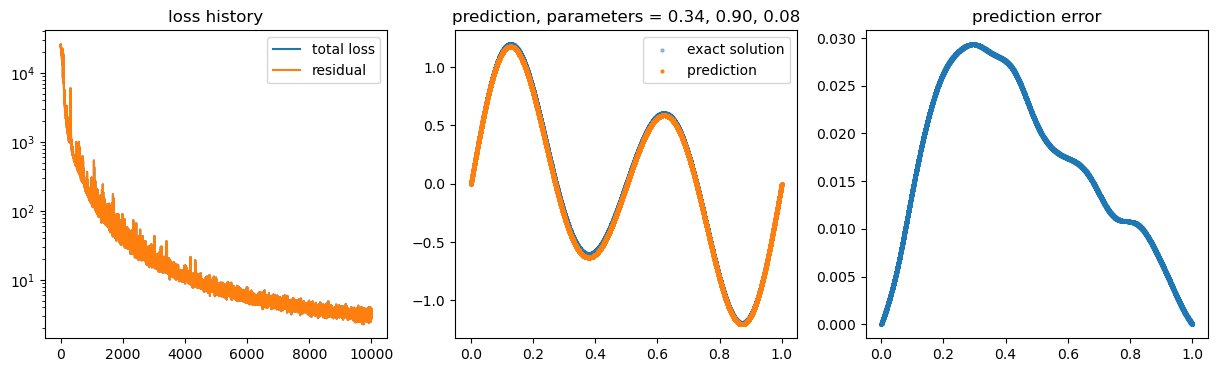

In [9]:
pde = Poisson_1D()
trainer,u_theta = Run_laplacian1D(pde)

## Error estimations

### Imports

In [10]:
from modfenics.error_estimations.fem import compute_error_estimations_fem_deg,compute_error_estimations_fem_all
from modfenics.error_estimations.add import compute_error_estimations_Corr_deg,compute_error_estimations_Corr_all
from modfenics.error_estimations.mult import compute_error_estimations_Mult_deg,compute_error_estimations_Mult_all

from modfenics.error_estimations.compare import plot_Corr_vs_FEM_alldeg
from modfenics.error_estimations.compare import plot_Mult_vs_FEM_alldeg_allM,plot_Mult_vs_Add_vs_FEM_alldeg_allM
from modfenics.error_estimations.compare import save_tab_alldeg_allM


/home/u2/lecourtier/miniconda3/envs/fenics_scimba_modules/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [11]:
param_num = config["error_estimations"]["param_num"]     
result_dir = testcase_dir + "/cvg/param"+str(param_num)+"/"
create_tree(result_dir)

### Run FEM

In [12]:
degree = 1
df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = compute_error_estimations_fem_deg(param_num,problem,degree,high_degree,new_run=False,result_dir=result_dir)

## Read csv file /home/u2/lecourtier/Article1/code/results/fenics/test_1D/testcase1/version1/cvg/param4/FEM_case1_v1_param4_degree1.csv


In [13]:
# compute_error_estimations_fem_all(param_num,problem,high_degree,new_run=False,result_dir=result_dir,plot_cvg=True)

### Run Add

In [14]:
degree = 1
df_Corr, tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = compute_error_estimations_Corr_deg(param_num,problem,degree,high_degree,u_theta,new_run=False,result_dir=result_dir)

## Read csv file /home/u2/lecourtier/Article1/code/results/fenics/test_1D/testcase1/version1/cvg/param4/Corr_case1_v1_param4_degree1.csv


In [15]:
# compute_error_estimations_Corr_all(param_num,problem,high_degree,u_theta,new_run=False,result_dir=result_dir,plot_cvg=True)

### Run Mult

In [16]:
tab_M = [3.0,100.0]

In [17]:
degree = 1
for M in tab_M:
    print("#### M = ",M)
    df_Mult, tab_nb_vert_Mult, tab_h_Mult, tab_err_Mult = compute_error_estimations_Mult_deg(param_num,problem,degree,high_degree,u_theta,M=M,new_run=False,result_dir=result_dir)

#### M =  3.0
## Read csv file /home/u2/lecourtier/Article1/code/results/fenics/test_1D/testcase1/version1/cvg/param4/Mult_case1_v1_param4_degree1_M3.0.csv
#### M =  100.0
## Read csv file /home/u2/lecourtier/Article1/code/results/fenics/test_1D/testcase1/version1/cvg/param4/Mult_case1_v1_param4_degree1_M100.0.csv


In [18]:
# for M in tab_M:
#     print("#### M = ",M)
#     df_Mult, tab_nb_vert_Mult, tab_h_Mult, tab_err_Mult = compute_error_estimations_Mult_deg(param_num,problem,high_degree,u_theta,M=M,new_run=False,result_dir=result_dir)

### Save results

In [19]:
# plot_Corr_vs_FEM_alldeg(param_num,problem,result_dir=result_dir)

In [20]:
# plot_Mult_vs_FEM_alldeg_allM(param_num,problem,tab_M,result_dir=result_dir)

Mult weak P1 M3.0 not found
Mult weak P1 M100.0 not found


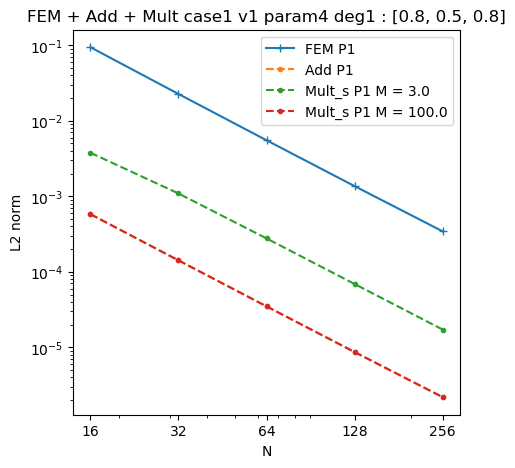

FEM P2 not found
Add P2 not found
Mult strong P2 M3.0 not found
Mult weak P2 M3.0 not found
Mult strong P2 M100.0 not found
Mult weak P2 M100.0 not found
No data found for param4 deg2
FEM P3 not found
Add P3 not found
Mult strong P3 M3.0 not found
Mult weak P3 M3.0 not found
Mult strong P3 M100.0 not found
Mult weak P3 M100.0 not found
No data found for param4 deg3


In [21]:
plot_Mult_vs_Add_vs_FEM_alldeg_allM(param_num,problem,tab_M,result_dir=result_dir)

In [22]:
save_tab_alldeg_allM(param_num,problem,tab_M,result_dir=result_dir)

Mult weak P1 M3.0 not found
Mult weak P1 M100.0 not found
FEM P2 not found
Corr P2 not found
Mult strong P2 M3.0 not found
Mult weak P2 M3.0 not found
Mult strong P2 M100.0 not found
Mult weak P2 M100.0 not found
FEM P3 not found
Corr P3 not found
Mult strong P3 M3.0 not found
Mult weak P3 M3.0 not found
Mult strong P3 M100.0 not found
Mult weak P3 M100.0 not found


/home/u2/lecourtier/Article1/code/src/modfenics/error_estimations/compare.py:203: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[error_cols] = df[error_cols].applymap(lambda x: f'{x:.2e}')
/home/u2/lecourtier/Article1/code/src/modfenics/error_estimations/compare.py:207: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[factor_cols] = df[factor_cols].applymap(lambda x: f'{round(x,2)}')


## Gains

### Imports

In [34]:
from modfenics.gains.fem import compute_error_fem_deg,compute_error_fem_all
from modfenics.gains.pinns import compute_error_pinns_deg,compute_error_pinns_all
from modfenics.gains.add import compute_error_Corr_deg,compute_error_Corr_all
from modfenics.gains.mult import compute_error_Mult_deg_allM,compute_error_Mult_alldeg_allM
from modfenics.gains.compare import create_dataframes_deg,create_dataframes_all,save_stats_deg,save_stats_all

In [24]:
n_params = config["gains"]["n_params"]   
result_dir = testcase_dir + "/gains/"
create_tree(result_dir) 

### Run FEM

In [25]:
degree = 1
df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = compute_error_fem_deg(n_params,problem,degree,high_degree,new_run=False,result_dir=result_dir)

## Read csv file /home/u2/lecourtier/Article1/code/results/fenics/test_1D/testcase1/version1/gains/FEM_errors_case1_v1_degree1.csv


In [14]:
# compute_error_fem_all(n_params,problem,high_degree,new_run=False,result_dir=result_dir)

### Run PINNs

In [26]:
degree = 1
df_PINNs, tab_nb_vert_PINNs, tab_h_PINNs, tab_err_PINNs = compute_error_pinns_deg(n_params,problem,degree,high_degree,u_theta,new_run=False,result_dir=result_dir)

## Read csv file /home/u2/lecourtier/Article1/code/results/fenics/test_1D/testcase1/version1/gains/PINNs_errors_case1_v1_degree1.csv


In [16]:
# compute_error_pinns_all(n_params,problem,high_degree,u_theta,new_run=False,result_dir=result_dir)

### Run Add

In [27]:
degree = 1
df_Corr, tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = compute_error_Corr_deg(n_params,problem,degree,high_degree,u_theta,new_run=False,result_dir=result_dir)

## Read csv file /home/u2/lecourtier/Article1/code/results/fenics/test_1D/testcase1/version1/gains/Corr_errors_case1_v1_degree1.csv


In [ ]:
# compute_error_Corr_all(n_params,problem,high_degree,u_theta,new_run=False,result_dir=result_dir)

### Run Mult

In [28]:
tab_M = [3.0,100.0]

In [36]:
degree = 1
compute_error_Mult_deg_allM(n_params,problem,degree,high_degree,u_theta,tab_M,new_run=False,result_dir=result_dir)

## Read csv file /home/u2/lecourtier/Article1/code/results/fenics/test_1D/testcase1/version1/gains/Mult_case1_v1_degree1_M3.0.csv
## Read csv file /home/u2/lecourtier/Article1/code/results/fenics/test_1D/testcase1/version1/gains/Mult_case1_v1_degree1_M100.0.csv


In [45]:
# compute_error_Mult_alldeg_allM(n_params,problem,high_degree,u_theta,tab_M,new_run=False,result_dir=result_dir)

### Compare methods

In [74]:
degree = 1
df_errors,df_gains = create_dataframes_deg(n_params,problem,degree,tab_M,result_dir=result_dir)

In [75]:
# create_dataframes_all(n_params,problem,result_dir=result_dir)

In [76]:
df_stats_Add = save_stats_deg(n_params,problem,degree,tab_M,result_dir=result_dir)

df_facteurs_n_vert : 
 facteurs        FEM/PINNs  PINNs/Corr    FEM/Corr PINNs/Mult3.0 FEM/Mult3.0  \
n_vert               20.0        20.0        20.0          20.0        20.0   
h                   0.053       0.053       0.053         0.053       0.053   
0 : 0.55,0.68    2.846883   54.661469   155.61479     43.467889  157.212672   
1 : 0.72,0.27   11.991086   20.166827   241.82217      7.470706  241.934324   
2 : 0.6,0.74      3.20331   52.770322  169.039716     29.609549    169.0575   
3 : 0.54,0.96    1.886016   68.892277  129.931949     17.723639  130.207238   
4 : 0.42,0.25    0.251361  105.374349   26.487029     69.793487   26.287849   
...                   ...         ...         ...           ...         ...   
95 : 0.18,0.49   1.906429   58.461725  111.453151     54.940314  112.189663   
96 : 0.59,0.23   0.502939   78.422872   39.441953     67.806869    39.44162   
97 : 0.02,0.25   2.661371   46.555624  123.901782      8.456288  123.319484   
98 : 0.83,0.06   0.758227  14

UnboundLocalError: local variable 'tab_gains_Add_on_PINNs' referenced before assignment